In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from prophet import Prophet
from sklearn.metrics import mean_squared_error
from statsmodels.api import qqplot

In [64]:
df = pd.read_csv("data/smhi-lufttemperatur.csv", sep=";")

### Data preprocessing

In [65]:
def transform(df_: pd.DataFrame) -> pd.DataFrame:
    """
    Description:
      Transform a pandas dataframe in the following way:
      1. Creates a datetime column (ds); concatenating the date-column (YYYY-MM-DD) with UTC time column.
      2. Renames the air temperature column so that it is compatible with the interface to facebook prophets API.
      3. Removes all observations that have a quality other than 'G'.
      4. Subsets for the datetime (ds) and air temperature (y) column.
      5. Sizes down air temperature (y) to an 8bit integer

    Args:
      df_ (pandas dataframe): Pandas dataframe to transform.

    Returns:
      Transformed dataframe.
    """
    return (df_
        .assign(ds=pd.to_datetime(df_["Datum"] + " " + df_["Tid (UTC)"]))
        .rename(columns={"Lufttemperatur": "y"})
        .query("Kvalitet != 'Y'")
        .loc[:, ("ds", "y")] # type: ignore
        .astype({"y": np.int8}))

In [66]:
# Function call to transform.
weather = transform(df)

In [67]:
weather

,ds,y
0,2010-03-01 00:00:00,2
3,2010-03-01 03:00:00,1
6,2010-03-01 06:00:00,1
9,2010-03-01 09:00:00,1
12,2010-03-01 12:00:00,1
...,...,...
108214,2022-08-01 02:00:00,16
108215,2022-08-01 03:00:00,16
108216,2022-08-01 04:00:00,16
108217,2022-08-01 05:00:00,17


In [69]:
# Earliest/latest observation and lowest/highest recorded temperature.
weather.min(), weather.max()

(ds    2010-03-01 00:00:00
 y                     -14
 dtype: object, ds    2022-08-01 06:00:00
 y                      30
 dtype: object)

In [70]:
# Number of null-values.
weather.isna().sum()

ds    0
y     0
dtype: int64

### Data exploration

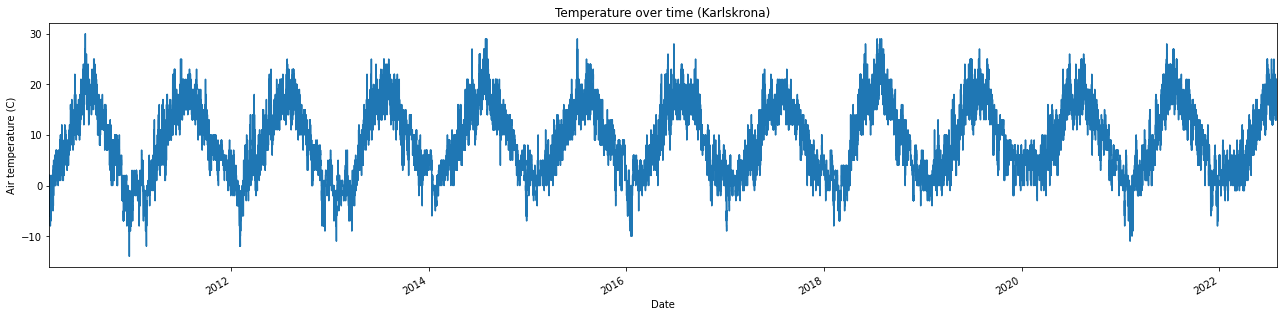

In [142]:
# Figure of air temperature over time.
(weather
 .plot(
     x="ds",
     y="y",
     title="Temperature over time (Karlskrona)",
     xlabel="Date", 
     ylabel="Air temperature (C)",
     legend=None,
     figsize=(22, 5),
     xlim=(weather["ds"].min(), weather["ds"].max())));

**From the above plot we can see a seasonal pattern.**

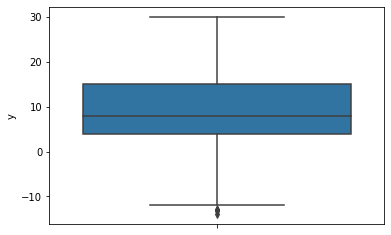

In [72]:
# Boxplot for outlier detection.
sns.boxplot(data=weather, y="y");

**We see very few values outside of the whiskers. Of these values, none seem overtly suspicious and we will therefore not remove them from the data set.**

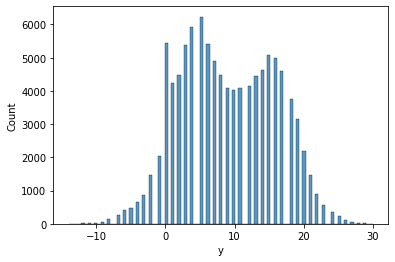

In [76]:
# Distribution plot of temperature.
sns.histplot(data=weather, x="y");

**The distribution seems bimodial.**

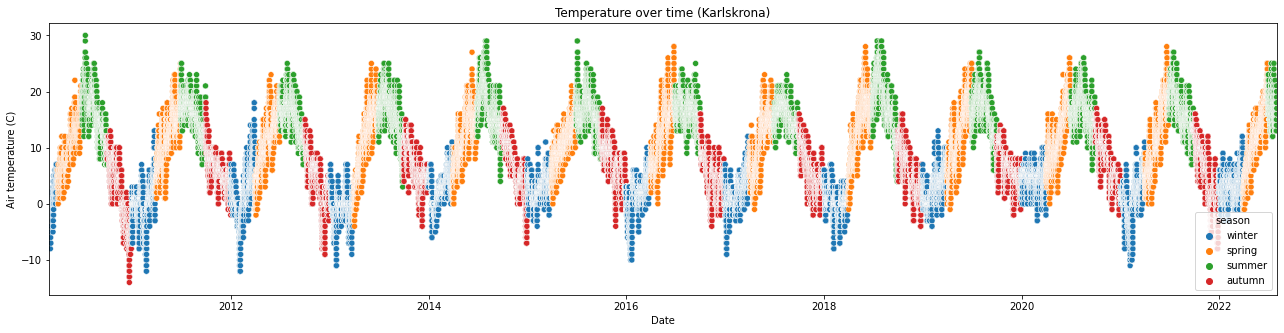

In [78]:
# Create a figure and axis object.
fig, ax = plt.subplots(figsize=(22, 5))

# Create a new feature: season.
temp = weather.assign(season=(((weather["ds"]).dt.month - 1) // 3))

# Map discrete values to their corresponding categories.
maping = {0: "winter", 1: "spring", 2: "summer", 3: "autumn"}
temp["season"] = temp.season.map(maping)

# Create plot and color according to season.
sns.scatterplot(data=temp, x="ds", y="y", hue="season", ax=ax)

# Configure plot.
ax.set(xlabel="Date", ylabel="Air temperature (C)", title="Temperature over time (Karlskrona)", xlim=(temp["ds"].min(), temp["ds"].max()))

# Show plot.
plt.show()

### 1. Spliting

In [79]:
# Split data into training and testing (80/20 split).
train = weather[weather["ds"] < pd.Timestamp("2020-02-25")]
test = weather[weather["ds"] >= pd.Timestamp("2020-02-25")]

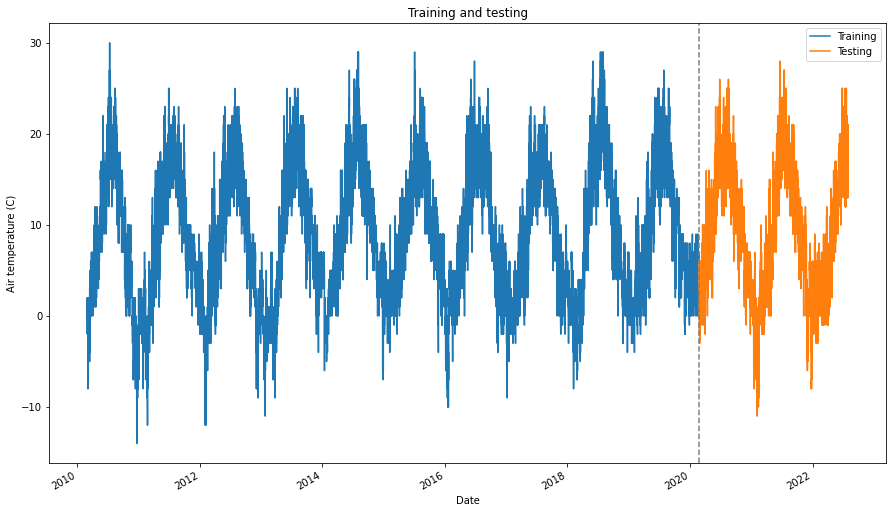

In [80]:
# Create a figure and axis object.
fig, ax = plt.subplots(figsize=(15, 9))

# Plot training and testing data.
train.plot(ax=ax, x="ds", y="y", label="Training")
test.plot(ax=ax, x="ds", y="y", label="Testing")

# Add a vertical line where training and testing split.
ax.axvline(test["ds"].min(), color="grey", ls="--")

# Prettifying plot.
ax.set(title="Training and testing", xlabel="Date", ylabel="Air temperature (C)")

# Show plot.
plt.show()

### 2. Modeling

In [81]:
%%time

# Instantiate and train model.
m = Prophet();
m.fit(train);

DEBUG:cmdstanpy:input tempfile: /tmp/tmp2w2n6uhd/1hueizi0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp2w2n6uhd/vopmgpon.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=41662', 'data', 'file=/tmp/tmp2w2n6uhd/1hueizi0.json', 'init=/tmp/tmp2w2n6uhd/vopmgpon.json', 'output', 'file=/tmp/tmp2w2n6uhd/prophet_model5a3b00co/prophet_model-20221229164756.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:47:56 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:49:54 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


CPU times: user 18.3 s, sys: 1.34 s, total: 19.6 s
Wall time: 2min 16s


In [84]:
# Create a dataframe with future dates we want to predict. We want the same dates as in our test set.
future = pd.DataFrame(dict(ds=test["ds"].values))

In [85]:
future

,ds
0,2020-02-25 00:00:00
1,2020-02-25 01:00:00
2,2020-02-25 02:00:00
3,2020-02-25 03:00:00
4,2020-02-25 04:00:00
...,...
21192,2022-08-01 02:00:00
21193,2022-08-01 03:00:00
21194,2022-08-01 04:00:00
21195,2022-08-01 05:00:00


In [86]:
# Forecasts on the dates in the future table.
forecast = m.predict(future)

In [87]:
# Lower, middle and upper predictions on 2022-08-01 from 02:00 untill 06:00.
forecast[["ds", "yhat", "yhat_lower", "yhat_upper"]].tail()

,ds,yhat,yhat_lower,yhat_upper
21192,2022-08-01 02:00:00,21.088114,-0.300402,42.532759
21193,2022-08-01 03:00:00,20.984804,-1.968213,41.771978
21194,2022-08-01 04:00:00,20.981610,-1.095580,42.100164
21195,2022-08-01 05:00:00,21.125689,-0.876210,42.248571
21196,2022-08-01 06:00:00,21.429622,-0.901153,42.841180


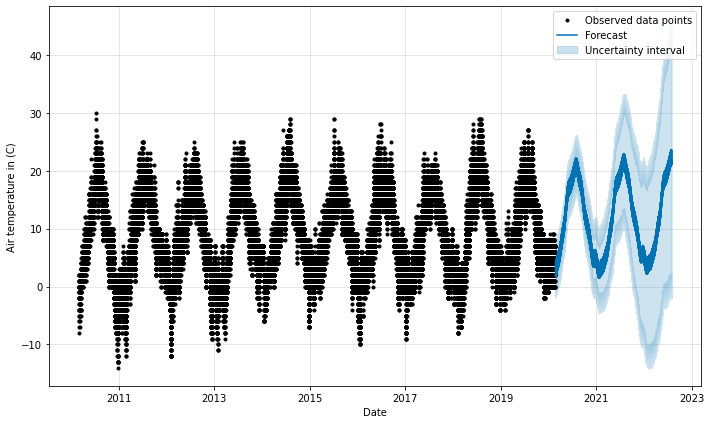

In [88]:
# Plot of our historical data and forecasts (with uncertainty intervals).
fsct_plot = m.plot(forecast, ylabel="Air temperature in (C)", xlabel="Date", include_legend=True)

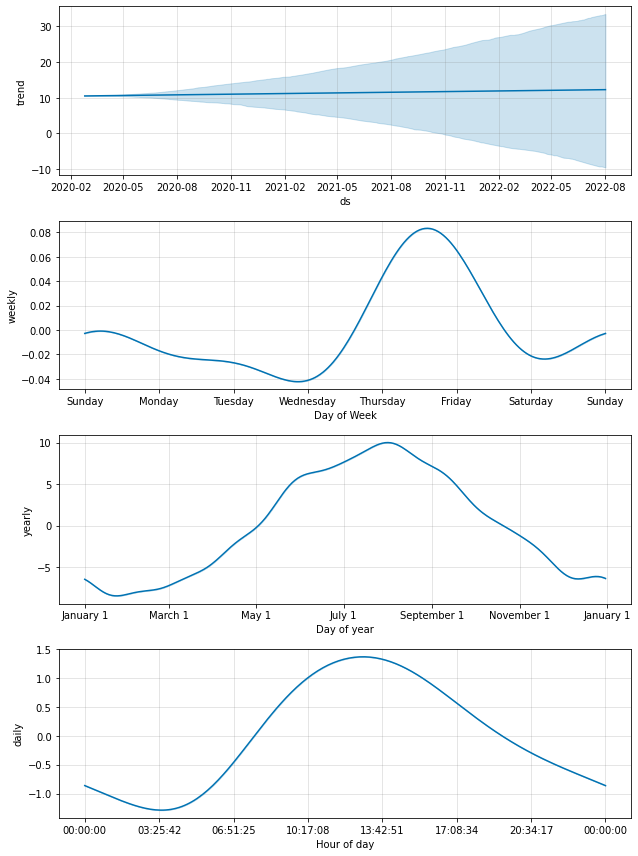

In [89]:
# Plot components that make up the additive regression function.
fsct_components = m.plot_components(forecast)

### 3. Evaluation

In [90]:
# Dataframe for our actual/predicted values and residuals.
pred = pd.DataFrame(
    dict(ds=test["ds"], 
         y=test["y"].values, 
         yhat=forecast["yhat"].values, 
         resid=(test["y"].values - forecast["yhat"].values)))

In [92]:
pred

,ds,y,yhat,resid
87022,2020-02-25 00:00:00,4,2.087614,1.912386
87023,2020-02-25 01:00:00,4,1.931757,2.068243
87024,2020-02-25 02:00:00,3,1.784910,1.215090
87025,2020-02-25 03:00:00,4,1.684018,2.315982
87026,2020-02-25 04:00:00,3,1.683131,1.316869
...,...,...,...,...
108214,2022-08-01 02:00:00,16,21.088114,-5.088114
108215,2022-08-01 03:00:00,16,20.984804,-4.984804
108216,2022-08-01 04:00:00,16,20.981610,-4.981610
108217,2022-08-01 05:00:00,17,21.125689,-4.125689


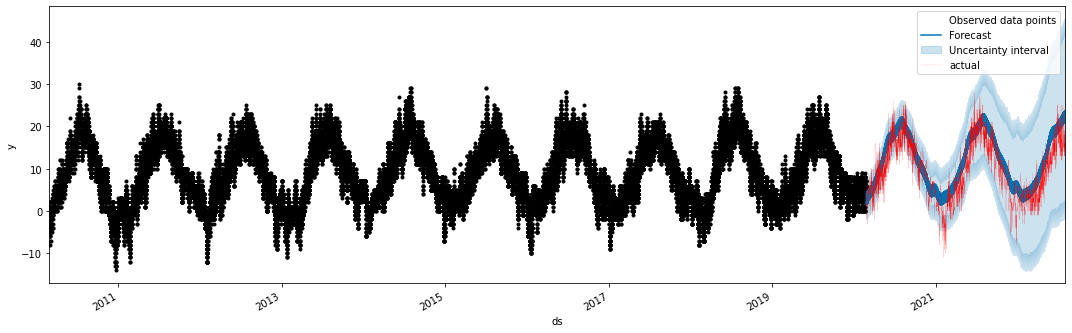

In [106]:
# Figure and axis-object.
fig, ax = plt.subplots(figsize=(15, 5))

# Cast over our test data onto the models predictions.
m.plot(forecast, include_legend=True, ax=ax)
test.plot(x="ds", y="y", label="actual", color="red", linewidth=0.1, ax=ax)

# Configure figure.
ax.set(xlim=(train["ds"].min(), test["ds"].max()))

# Show plot.
plt.show()

### Resid plot
Shows whether or not the residuals go positive or negative as the fitted values change.

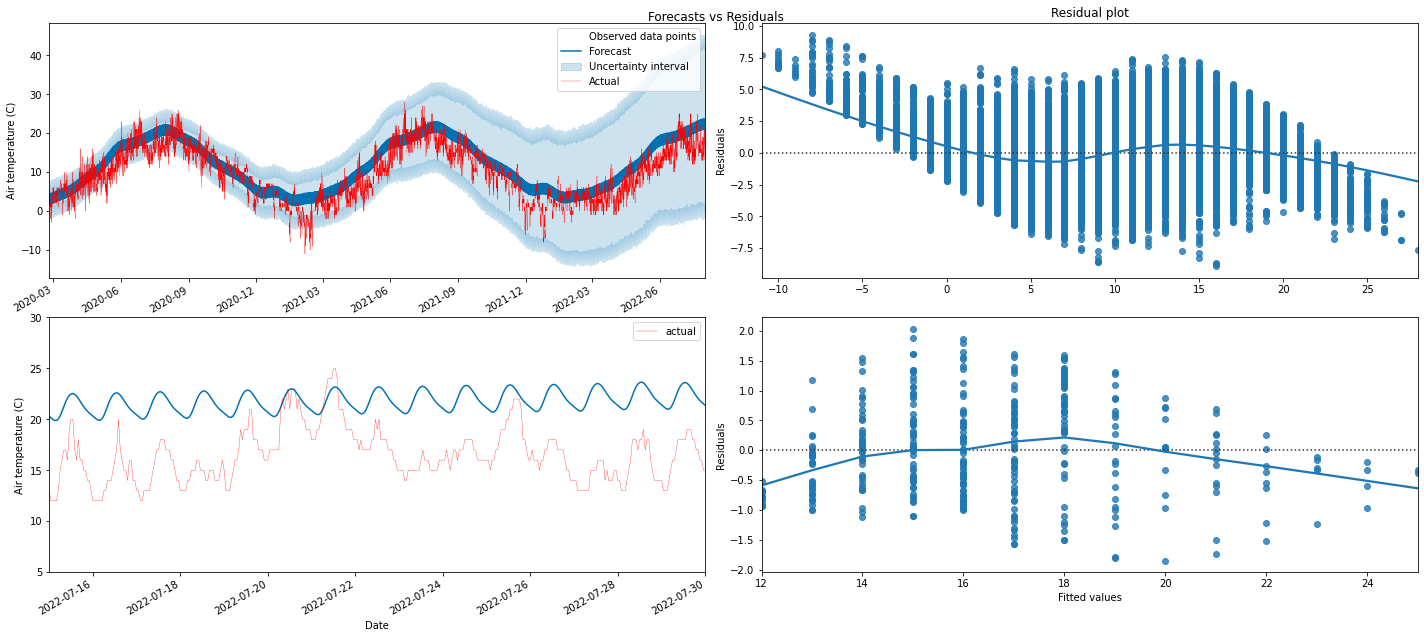

In [132]:
# Figure and axis-object.
fig, (ax1, ax2) = plt.subplots(2, 2, figsize=(20, 10))
fig.suptitle("Forecasts vs Residuals")

# Plot predictions versus actuals.
m.plot(forecast, include_legend=True, ax=ax1[0])
pred.plot(x="ds", y="y", label="Actual", color="red", linewidth=0.3, ax=ax1[0])
ax1[0].set(xlabel=None, ylabel="Air temperature (C)", xlim=(forecast["ds"].min(), forecast["ds"].max()))

# Plot the residuals vs. fitted values.
sns.residplot(x="y", y="yhat", data=pred, lowess=True, ax=ax1[1])
ax1[1].set(title="Residual plot", xlabel=None, ylabel="Residuals")

# Plot predictions versus actuals.
m.plot(forecast, uncertainty=False, ax=ax2[0])
test.plot(x="ds", y="y", label="actual", color="red", linewidth=0.3, ax=ax2[0])
ax2[0].set(xlabel="Date", ylabel="Air temperature (C)", xlim=("2022-07-15", "2022-07-30"), ylim=(5, 30))

# Plot the residuals vs. fitted values.
sns.residplot(x="y", y="yhat", data=pred.query("'2022-07-15' <= ds <= '2022-07-30'"), lowess=True, ax=ax2[1])
ax2[1].set(xlabel="Fitted values", ylabel="Residuals")

# Show plot.
plt.show()

- **Lowess** is a smooth curve following the data (trend)
- If residuals met the assumtion that they are normaly distributed, with mean zero, than the trend line should closely follow the `y = 0` line in the plot.

#### QQ-plot
It shows whether or not the residuals follow a normal distribution. 
- On the x-axis the points are quantiles from the normal distribution.
- On the y-axis you get the sample quantiles which are quantiles derived from your data set.

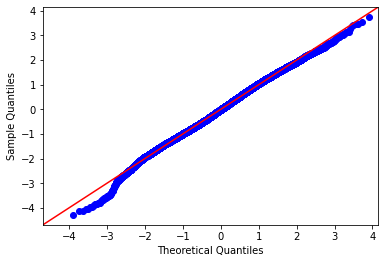

In [133]:
# Create the Q-Q plot of the residuals
qqplot(data=pred["resid"], fit=True, line="45");

**If the points track along the straight line, then they are normaly distributed, if they not then they aren't.**

In [166]:
# Largest residuals.
(pred
 .assign(abs_resid=pred.resid.abs())
 .nlargest(n=5, columns=["abs_resid"]))

,ds,y,yhat,resid,abs_resid
103011,2021-12-25 09:00:00,-8,6.215382,-14.215382,14.215382
103010,2021-12-25 08:00:00,-8,5.756589,-13.756589,13.756589
102997,2021-12-24 19:00:00,-8,5.738128,-13.738128,13.738128
103012,2021-12-25 10:00:00,-7,6.591294,-13.591294,13.591294
102994,2021-12-24 16:00:00,-7,6.581001,-13.581001,13.581001


In [167]:
# Smallest residuals.
(pred
 .assign(abs_resid=pred.resid.abs())
 .nsmallest(n=5, columns=["abs_resid"]))

,ds,y,yhat,resid,abs_resid
94995,2021-01-23 18:00:00,3,3.000242,-0.000242,0.000242
99428,2021-07-28 09:00:00,22,22.000396,-0.000396,0.000396
91630,2020-09-04 12:00:00,19,18.999520,0.000480,0.000480
92985,2020-10-31 06:00:00,9,9.000683,-0.000683,0.000683
92463,2020-10-09 10:00:00,13,12.999227,0.000773,0.000773


In [168]:
# MSE.
mean_squared_error(pred["y"], pred["yhat"])

12.658488465297626

In [170]:
# RMSE.
np.sqrt(mean_squared_error(pred["y"], pred["yhat"]))

3.5578769603933225